## Thompson GAN experiment on MNIST 0vs1 (only zeros and ones) 

We don't care about tuning our GAN for now and just rip everything from the tf DC-GAN tutorial.
https://www.tensorflow.org/tutorials/generative/dcgan


In [1]:
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
#import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from scipy.stats import beta
#from IPython import displaydd

## Here we have all the Thompson sampling magic.

* self.stats - We store the outcome statistics in stats, (number of correct fake/real classifications per discriminator)
* self.n_cluster - Just the number of discriminators we use
* self.X - all the dataz aka all the samples


Note that we sample from a beta distribution since it is the conjugate prior to the bernoulli distribution (probability of beeing right or wrong)
https://davidrosenberg.github.io/mlcourse/in-prep/thompson-sampling-bernoulli.pdf 

Also note that each *sample* has its own beta distribution! This is because whe make an *allocation decision* for each sample


Basically this object holds the data, keeps track of the fake/real classification statisics and finally does the sampling and assignment of samples at the start of each epoch.

In [2]:
class DataHolder(object):
    
    def __init__(self,n_clusters,X):
        #sucess index = 0
        self.X = X
        self.n_clusters = n_clusters
        self.stats = np.ones((len(X),n_clusters,2),dtype = int)
    
    def update(self,sample_index,cluster_index,outcome):
        self.stats[sample_index,cluster_index,outcome]+=1
    
    def assign(self):
        assignment=[]
        for sample in self.stats:
            assignment.append(np.argmax([beta.rvs(*component) for component in sample]))
        
        assignment = np.asarray(assignment)
        assignment_indices = [np.where(assignment == k)[0] for k in range(self.n_clusters)]
        assignment_data  = [self.X[indices] for indices in assignment_indices]
        return assignment_indices,assignment_data

## The rest of this is just the standard GAN yoga but with multiple (2) discriminators.
Compare to 00-me-MNIST-experiment.ipynb for the standard GAN

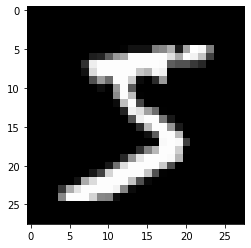

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[0],cmap = 'gray')
plt.show()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [6]:
# Batch and shuffle the data
#dataset1 = tf.data.Dataset.from_tensor_slices(train_images[train_labels<=4]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#dataset2 = tf.data.Dataset.from_tensor_slices(train_images[train_labels>4]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

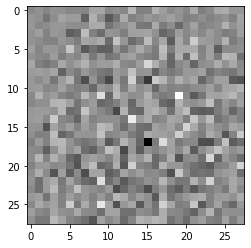

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()

n_discriminators=2

discriminators = [make_discriminator_model() for _ in range(n_discriminators)]

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizers = [tf.keras.optimizers.Adam(1e-4) for _ in range(n_discriminators)]

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape1, tf.GradientTape() as disc_tape2:
        
        disc_tapes = [disc_tape1,disc_tape2]
        
        generated_images = generator(noise, training=True)
        
        real_outputs = [discriminator(images[i], training=True) for i, discriminator in enumerate(discriminators)]
        fake_outputs = [discriminator(generated_images, training=True) for discriminator in discriminators]
        
        gen_loss = 0
        for fake_output in fake_outputs:
            gen_loss+= generator_loss(fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        for real_output,fake_output,disc_tape,disc_optimizer,discriminator in zip(real_outputs,fake_outputs,disc_tapes,discriminator_optimizers,discriminators):
            disc_loss = discriminator_loss(real_output, fake_output)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return real_outputs

In [17]:
def train(epochs):
    for epoch in range(epochs):
        start = time.time()
        
        #print('stuck on assign')
        indices, images = dataholder.assign()
        #print('not really')
        min_len = np.min([len(indices[0]), len(indices[1])])
        #print(min_len, min_len/BATCH_SIZE)
        dataset1 = tf.data.Dataset.from_tensor_slices((images[0],indices[0])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        dataset2 = tf.data.Dataset.from_tensor_slices((images[1],indices[1])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        
        outcomes = [[] for _ in range(n_discriminators)]
        iiii=0
        for batch1,batch2 in zip(dataset1,dataset2):
            #print(iiii)
            iiii+=1
            images = (batch1[0],batch2[0])
            indices = (batch1[1],batch2[1])
            #print('stuck on step')
            step_outcomes = train_step(images)
            #print('not ')
            d_idx=0
            for ind,outcome in zip(indices,step_outcomes):
                outcome = (outcome < 0).numpy().astype(int).reshape(-1) ## Remember the invese alocation stuff due to a,b order in beta distribution
                dataholder.update(sample_index = ind,
                                  cluster_index = d_idx * np.ones_like(ind,dtype=int),
                                  outcome=outcome)
            
                d_idx+=1
            

        # Produce images for the GIF as we go
        #display.clear_output(wait=True)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
            pass
        
        

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [19]:
dataholder = DataHolder(n_clusters = 2, X=train_images[train_labels <=1])
dataset = tf.data.Dataset.from_tensor_slices((train_images[train_labels<=1],train_labels[train_labels<=1])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Training

In [20]:
for epep in range(10):
    
    #Train 5 epochs
    train(5)
    
    
    
    #Evaluate ( Yes this looks like shit)
    res = []
    labels = []
    for imgs,lbls in dataset:
        out0 = discriminators[0](imgs,training = False)
        out1 = discriminators[1](imgs,training = False)



        am = np.argmax(np.concatenate((out0,out1),axis = 1),axis=1)
        res.extend(lbls.numpy()==am)


    res = np.asarray(res)
    c = np.sum(res)/len(res)

    print('Purity {:.3f}'.format(np.max([1-c,c])))

Time for epoch 1 is 5.035049915313721 sec
Time for epoch 2 is 3.019049644470215 sec
Time for epoch 3 is 3.0498740673065186 sec
Time for epoch 4 is 3.0590884685516357 sec
Time for epoch 5 is 2.103208303451538 sec
Purity 0.636
Time for epoch 1 is 3.1095962524414062 sec
Time for epoch 2 is 3.157282590866089 sec
Time for epoch 3 is 2.960153818130493 sec
Time for epoch 4 is 2.930058002471924 sec
Time for epoch 5 is 2.9637510776519775 sec
Purity 0.687
Time for epoch 1 is 3.120543956756592 sec
Time for epoch 2 is 3.0372989177703857 sec
Time for epoch 3 is 3.0129992961883545 sec
Time for epoch 4 is 3.021333932876587 sec
Time for epoch 5 is 3.196162700653076 sec
Purity 0.831
Time for epoch 1 is 2.9458229541778564 sec
Time for epoch 2 is 3.0032927989959717 sec
Time for epoch 3 is 2.981215238571167 sec
Time for epoch 4 is 2.943000316619873 sec
Time for epoch 5 is 3.2892229557037354 sec
Purity 0.904
Time for epoch 1 is 2.91823410987854 sec
Time for epoch 2 is 2.9010562896728516 sec
Time for epoch 

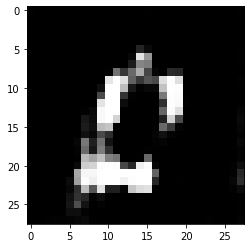

In [33]:
noise = tf.random.normal([3, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
#very nize zero

In [ ]:
from collections import Counter

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(2)


X = train_images[train_labels <=1]
X = X.reshape((X.shape[0],np.prod(X.shape[1:])))
y = train_labels[train_labels <=1]
km.fit(X)
p = km.predict(X)

c = np.sum(y==p)/len(y)
print('purity: {:.3f}'.format(np.max([c,1-c])))

In [ ]:
Counter(y)